# News Analysis with LLM (Gemini)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [2]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [3]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [4]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format:

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.]

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("../../DataCollection/Data/News/SETI_2025-05-27_12-55-53.csv")
display(df.head())

,ticker,publish_date,publish_time,title,body_text,url
0,SETI,2025-04-27,23:39,Asia stocks mixed amid US-China trade uncertai...,Investing.com-- Asian stock markets were mixed...,https://www.investing.com/news/stock-market-ne...
1,SETI,2025-04-24,18:42,US reinstates Thailand’s top aviation safety r...,By David Shepardson\n\nWASHINGTON (Reuters) - ...,https://www.investing.com/news/stock-market-ne...
2,SETI,2025-04-21,00:34,Asia stocks mixed: China ticks up as PBoC stay...,Investing.com-- Asian stocks were mixed in Mon...,https://www.investing.com/news/stock-market-ne...
3,SETI,2025-03-31,23:45,Asia stocks rise tracking Wall St ahead of Tru...,Investing.com-- Asian stocks rebounded on Tues...,https://www.investing.com/news/stock-market-ne...
4,SETI,2025-03-24,21:50,Southeast Asian stocks feel the heat from econ...,By Patturaja Murugaboopathy and Ankur Banerjee...,https://www.investing.com/news/stock-market-ne...


In [7]:
df.isnull().sum()

ticker          0
publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [8]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [9]:
print(df.head())

  ticker publish_date publish_time  \
0   SETI   2025-04-27        23:39   
1   SETI   2025-04-24        18:42   
2   SETI   2025-04-21        00:34   
3   SETI   2025-03-31        23:45   
4   SETI   2025-03-24        21:50   

                                               title  \
0  Asia stocks mixed amid US-China trade uncertai...   
1  US reinstates Thailand’s top aviation safety r...   
2  Asia stocks mixed: China ticks up as PBoC stay...   
3  Asia stocks rise tracking Wall St ahead of Tru...   
4  Southeast Asian stocks feel the heat from econ...   

                                           body_text  \
0  Investing.com-- Asian stock markets were mixed...   
1  By David Shepardson\n\nWASHINGTON (Reuters) - ...   
2  Investing.com-- Asian stocks were mixed in Mon...   
3  Investing.com-- Asian stocks rebounded on Tues...   
4  By Patturaja Murugaboopathy and Ankur Banerjee...   

                                                 url  
0  https://www.investing.com/news/stock-ma

In [10]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "Unknown Stock")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting: 100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


In [11]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [12]:
print(df["title"][2],'\n\n',predicted[2])

Asia stocks mixed: China ticks up as PBoC stays pat; Japan drops after strong CPI By Investing.com 

 **Sentiment:**
Neutral

**Summary:**
Asian stock markets were mixed on Monday, with China rising slightly after its central bank kept loan prime rates unchanged, while Japan fell following stronger-than-expected inflation data. Trading volumes were subdued due to holidays in several countries, and investors remained cautious about global trade tensions.

**Reasoning for Sentiment:**
The article describes a "mixed" performance across Asian markets, detailing both gains in some regions (China, Singapore) and losses in others (Japan, Thailand), reflecting divergent trends rather than a uniform positive or negative outlook.

**Importance to Stock SETI:**
4

**Reasoning for Importance:**
The article directly reports on the performance of Thailand's stock market (SETI), stating that it fell by 0.4% on the day, providing specific and relevant data for the index. It also contextualizes this mo

In [13]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [14]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
3,2025-03-31,Asia stocks rise tracking Wall St ahead of Tru...,Neutral,5,"Asian stocks rose on Tuesday, tracking Wall St..."
4,2025-03-24,Southeast Asian stocks feel the heat from econ...,Negative,5,Foreign investors are pulling money out of Sou...
6,2025-02-26,Thai central bank cuts policy rate amid slow g...,Positive,5,Thailand's central bank cut its benchmark inte...
7,2025-02-17,"Thai Q4 GDP growth misses forecast, U.S. trade...",Negative,5,"Thailand's Q4 GDP growth missed forecasts, and..."
9,2025-02-10,Thailand to set up long-term equity fund to su...,Positive,5,Thailand's government plans to establish a new...
10,2025-02-06,"Asia stocks mixed with gains in China shares, ...",Negative,5,Most Asian stock markets declined due to globa...
11,2025-02-03,Asia stocks rebound on Trump tariff delays; Ch...,Positive,5,Asian stocks rebounded significantly after the...
12,2025-02-02,Asia stocks plunge as Trump tariffs spark glob...,Negative,5,Asian stock markets experienced a significant ...
14,2025-01-14,"Asia stocks inch up tracking Wall Street, spot...",Neutral,5,"Asian stocks exhibited mixed performance, with..."
16,2024-12-16,Asia stocks mixed ahead of major interest rate...,Neutral,5,Asian stock markets showed mixed performance a...


In [15]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,ticker,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [16]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

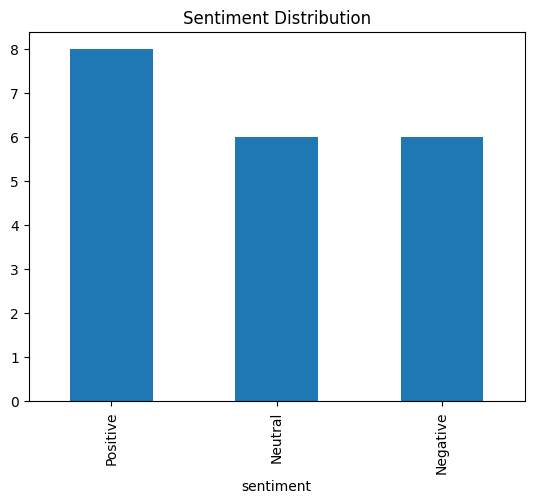

In [17]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

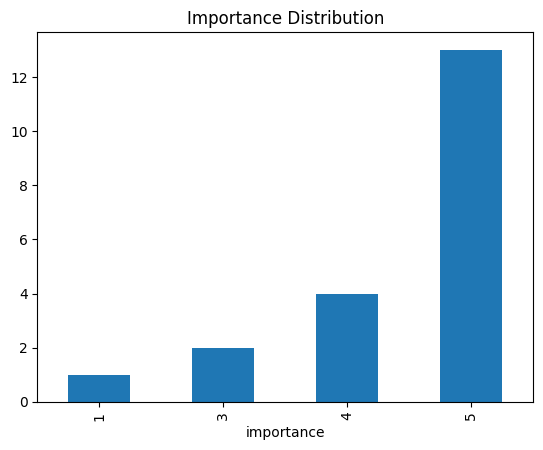

In [18]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [19]:
TICKER=df["ticker"][0]

In [20]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [21]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [22]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for SETI: 0.06


In [23]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini_{TICKER}_{date_time}.csv", index=False)